In [1]:
import torch
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import MLP as sf
from MLP import training

## Classi e funzioni utili

## Importazione e preparazione dati

In [2]:
le = LabelEncoder()
df = pd.read_csv('star_classification.csv')
display(df)
df['class'] = le.fit_transform(df['class'])

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [3]:
scaler = StandardScaler()

In [4]:
X_clas = df.drop(['run_ID', 'rerun_ID', 'fiber_ID', 'spec_obj_ID', 'fiber_ID', 'obj_ID', 'class'], axis=1)
y_clas = df['class']
X_clas = scaler.fit_transform(X_clas)
y_clas = y_clas.values
y_clas = y_clas.reshape((-1,1))

In [5]:
X_regr = df.drop(['run_ID', 'rerun_ID', 'fiber_ID', 'spec_obj_ID', 'fiber_ID', 'obj_ID', 'redshift', 'class'], axis=1)
y_regr = df['redshift']
X_regr = scaler.fit_transform(X_regr)
y_regr = y_regr.values
y_regr = y_regr.reshape((-1,1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_clas, y_clas, test_size=0.2, shuffle=True, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_regr, y_regr, test_size=0.2, shuffle=True, random_state=42)

In [7]:
if torch.cuda.is_available():
    print('Numero di GPU disponibili: ',torch.cuda.device_count())
    for i in range(0,torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



## Definizione della rete neurale di classificazione

In [19]:
modello_cls = sf.MLP(input_size=X_train.shape[1], hidden_size=[258,182,128,60,30], output_size=3, type='cls_multi')
X_train_cls, y_train_cls, X_test_cls, y_test_cls, dataloader_train, dataloader_test = modello_cls.data_system(batch_train=600, batch_test=600, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [20]:
modello_cls.compile(modello=modello_cls, X=X_train_cls)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 600, 258]           3,354
              ReLU-2             [-1, 600, 258]               0
            Linear-3             [-1, 600, 182]          47,138
              ReLU-4             [-1, 600, 182]               0
            Linear-5             [-1, 600, 128]          23,424
              ReLU-6             [-1, 600, 128]               0
            Linear-7              [-1, 600, 60]           7,740
              ReLU-8              [-1, 600, 60]               0
            Linear-9              [-1, 600, 30]           1,830
             ReLU-10              [-1, 600, 30]               0
           Linear-11               [-1, 600, 3]              93
          Softmax-12               [-1, 600, 3]               0
Total params: 83,579
Trainable params: 83,579
Non-trainable params: 0
---------------------------------

In [21]:
acc, loss, epoche = training(modello=modello_cls, X_train=X_train_cls, y_train=y_train_cls, dataloader=dataloader_train, epochs=10, type='cls_multi')

Epoch [1/30], Loss: 0.0058, Accuratezza: 0.7042
Epoch [2/30], Loss: 0.0061, Accuratezza: 0.7550
Epoch [3/30], Loss: 0.0060, Accuratezza: 0.7572
Epoch [4/30], Loss: 0.0057, Accuratezza: 0.7579
Epoch [5/30], Loss: 0.0053, Accuratezza: 0.7784
Epoch [6/30], Loss: 0.0045, Accuratezza: 0.9189
Epoch [7/30], Loss: 0.0046, Accuratezza: 0.9556
Epoch [8/30], Loss: 0.0045, Accuratezza: 0.9594
Epoch [9/30], Loss: 0.0044, Accuratezza: 0.9616
Epoch [10/30], Loss: 0.0044, Accuratezza: 0.9638
Epoch [11/30], Loss: 0.0044, Accuratezza: 0.9634
Epoch [12/30], Loss: 0.0044, Accuratezza: 0.9622
Epoch [13/30], Loss: 0.0044, Accuratezza: 0.9651
Epoch [14/30], Loss: 0.0045, Accuratezza: 0.9622
Epoch [15/30], Loss: 0.0045, Accuratezza: 0.9641
Epoch [16/30], Loss: 0.0044, Accuratezza: 0.9634
Epoch [17/30], Loss: 0.0044, Accuratezza: 0.9642
Epoch [18/30], Loss: 0.0044, Accuratezza: 0.9645
Epoch [19/30], Loss: 0.0043, Accuratezza: 0.9652
Epoch [20/30], Loss: 0.0044, Accuratezza: 0.9655
Epoch [21/30], Loss: 0.0045, 

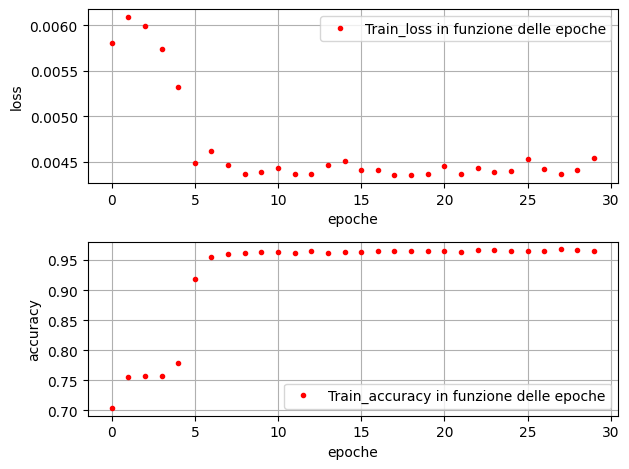

In [22]:
modello_cls.plot(acc, loss, epoche)

## Definizione del modello di regressione

In [12]:
modello_reg = sf.MLP(input_size=X_train2.shape[1], hidden_size=[128,128], output_size=1, type='reg')
X_train_reg, y_train_reg, X_test_reg, y_test_reg, dataloader_train2, dataloader_test2 = modello_reg.data_system(batch_train=512, batch_test=512, X_train=X_train2, y_train=y_train2, X_test=X_test2, y_test=y_test2)

In [13]:
modello_reg.compile(modello=modello_reg, X=X_train_reg)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 512, 128]           1,536
              ReLU-2             [-1, 512, 128]               0
            Linear-3             [-1, 512, 128]          16,512
              ReLU-4             [-1, 512, 128]               0
            Linear-5               [-1, 512, 1]             129
Total params: 18,177
Trainable params: 18,177
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.00
Params size (MB): 0.07
Estimated Total Size (MB): 2.09
----------------------------------------------------------------


In [14]:
loss, epoche = training(modello=modello_reg, X_train=X_train_reg, y_train=y_train_reg, dataloader=dataloader_train2, epochs=10, type='reg')

Epoch [1/10], Loss: 0.0027
Epoch [2/10], Loss: 0.0018
Epoch [3/10], Loss: 0.0027
Epoch [4/10], Loss: 0.0014
Epoch [5/10], Loss: 0.0025
Epoch [6/10], Loss: 0.0024
Epoch [7/10], Loss: 0.0029
Epoch [8/10], Loss: 0.0018
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0019


NameError: name 'epoche' is not defined